<a href="https://colab.research.google.com/github/janchorowski/nn_assignments/blob/nn18/lectures/14_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder introduction
Unsupervised learning algorithms are often used for *representation learning*, where the goal is to learn a useful and nontrivial representation of data.  AutoEncoders are representation learners that contain two models:
1. an *encoder* which encodes a data sample $x$ into a latent representation $z$,
2. a *decoder* which decodes $z$ into a reconstruction $\bar{x}$.

Autoencoders are trained to reconstruct the data (making $\bar{x}$ close to $x$). However, getting perfect reconstructions is not a goal in and out of itself. Imagine that the encoder learns the identity function $z(z)=x$. While this representation makes perfect decoding easy, it is by itself no more useful than the raw data alone!

To promote nontrivial representations, the latent code $z$ must be constrained in some way.

# Examples
## Matrix factorization
For instance, assume that the encoder reduces the dimensionality of $x$. Let $X\in \mathbb{R}^{d\times n}$ be the data matrix containing $n$ $d$-dimensional data points. The encoder assigns to each sample $x\in\mathbb{R}^d$ a latent code $z\in\mathbb{R}^{k}$. Then the decoder reconstructs $x$ by a linear projection $\bar{x}=Dz$.

In other words, we are approximating the data matrix $X$ with 
$$
X\approx DZ = \bar{X}
$$

This is a matrix factorization model - we are factorizing a data matrix of rank $d$ into a low-rank product of two matrices, $D$ and $Z$, both of rank $k<d$.

The SVD algorithm gives us the best (in the least squares sense) low-rank approximation. The factorizatoin decomposes $X$ into
$$
X = U\Sigma V^T
$$
Where $U$ and $V$ are orthornormal and $\Sigma$ is diagonal. We can reduce the data dimensionality by limiting $U$ and $V$ to contain only the $k$ entries corresponding to the $k$ larges singular values (entries in $\Sigma$).
$$
X \approx U_k\Sigma_k V_k^T
$$
where $U_k$, $V_k$ and Sigma_k$ are the matrices $u$, $V$, and $\Sigma$ corresponding to the $k$ largest singular values. Moreover, in the case of SVD the encoder is simply a linear projection of the data:

$$
Z(X) = U_k^TX = U_K^T(U\Sigma V^T) = \Sigma_k V_k^T
$$

and the decoder is also a linear projection:

$$
\bar{X} = U_k Z
$$


## k-Means

The k-Means algorithm can also be analyzed from an auto-encoding perspective. Recall that the k-Means algorithm assigns each data point to one of $K$ clusters, effectively replacing the data point with the center of the cluster. This can be seen as an autoencoding behavior: the encoder represents each point by the cluster id (the code $z$ is a natural number). Then the decoder returns the center of the cluster. The representation is constrained, because we force the encoder to choose only one cluster for each data point.

To get further insights, we will express the k-Means algorithm in matrix format. Let $X\in \mathbb{R}^{d\times n}$ be the data matrix containg $n$ $d$-dimensional data points. if there are $k$ clusters, then $Z$ will be a $k\times n$ matrix such that each column is all zeros, except for one entry whose value is 1. Finally, let $D$ be a $d\times k$ matrix of cluster centers. We can now approximate the data matrix by

$$
X\approx \bar{X} = DZ.
$$

In the case of k-Means the encoder performs a nonlinear operation of mapping each data point to its cluster, expressed as a 1-hot vector. The decoder remains linear.

## Other constraints for $z$

Dimensionality reduction and k-Means are two extreme autoencoder kinds. On the one hand, dimensionality reduction, implemented as SVD factorization encodes each data point as a linear combination of all columns from the $D$ matrix. On the other hand, k-Means emcode each sample as a single column of the $D$ matrix. A popular constraint, called sparse coding, is a relaxation of k-Means: each data sample is a combination of only a few columns from the $D$ matrix. In the sparse coding approach, we often call $D$ the dictionary and see each sample as a combination of a few atoms from the dictionary.

Similarly to k-Means, encoding is a nonlinear procedure, which involves finding a smalles set of dictionary elements which reconstruct X. Decoding, however, is again a linear operation.

# Neural autoencoders

An autoencoding neural network implements the encoder and decoder using neural networks. Again, constraints need to be applied to the latent representation to prevent learning an easily recoverable encoding, such as an invertible affine projection.

In the code below we explore a dimansionality reduction autoencoder (which is prone to find encoding similar to the SVD solution) and a sparse auto-encoder in which we enforce sparsity of the latent representation.



In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [0]:
%matplotlib inline

In [0]:
!pip install -q gdown httpimport
![ -e cifar.npz ] || gdown 'https://drive.google.com/uc?id=1oBzZdtg2zNTPGhbRy6DQ_wrf5L5OAhNR' -O cifar.npz
![ -e mnist.npz ] || gdown 'https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU' -O mnist.npz

In [0]:
!pip install -q spams_mkl

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
import os
import re

import httpimport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.utils.data
from torch import nn
import torch.nn.functional as F

# In this way we can import functions straight from github
with httpimport.github_repo('janchorowski', 'nn_assignments', 
                            module='common', branch='nn18'):
     from common.plotting import plot_mat
        
sns.set_style('whitegrid')

def n(t):
    return t.detach().cpu().numpy()

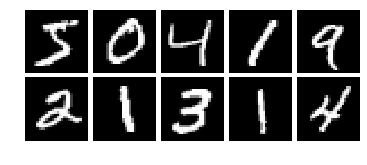

In [8]:
with np.load('mnist.npz') as data:
    mnist_full_train_data = data['train_data'].astype('float32') / 255.0
    mnist_full_train_labels = data['train_labels']
    mnist_test_data = data['test_data'].astype('float32') / 255.0
    mnist_test_labels = data['test_labels']

plot_mat(mnist_full_train_data[:10, None], cmap='gray')

In [0]:
class InMemDataLoader(object):
    __initialized = False
    def __init__(self, tensors, batch_size=1, shuffle=False, sampler=None,
                 batch_sampler=None, drop_last=False):
        """A torch dataloader that fetches data from memory."""
        tensors = [torch.tensor(tensor) for tensor in tensors]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last
        
        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError('batch_sampler option is mutually exclusive '
                                 'with batch_size, shuffle, sampler, and '
                                 'drop_last')
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError('sampler option is mutually exclusive with '
                             'shuffle')
            
        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(sampler, batch_size, drop_last)

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True
    
    def __setattr__(self, attr, val):
        if self.__initialized and attr in ('batch_size', 'sampler', 'drop_last'):
            raise ValueError('{} attribute should not be set after {} is '
                             'initialized'.format(attr, self.__class__.__name__))

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)
    
    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

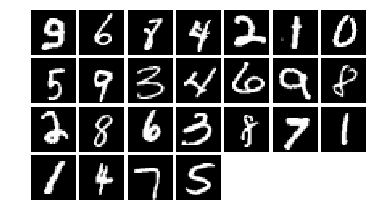

In [10]:
train_loader = InMemDataLoader(
    (mnist_full_train_data, ), batch_size=100, shuffle=True)
test_loader = InMemDataLoader(
    (mnist_test_data, ), batch_size=100, shuffle=False)

batch_x, = next(iter(train_loader))
plot_mat(batch_x.numpy()[:25,None,:,:], cmap='gray')

# SVD factorization

In [0]:
mnist_full_train_data_flat = mnist_full_train_data.reshape(-1, 28*28)
mnist_full_train_data_flat_norm = (
    mnist_full_train_data_flat - mnist_full_train_data_flat.mean(axis=0, keepdims=True))

In [0]:
# For svd, we will assume that the X matrix is dim x n_samples
X = mnist_full_train_data_flat_norm.T
U,S,V_t = np.linalg.svd(X, full_matrices=0)

For SVD the least-squares reconstruction error is given by the sum of singular values that we remove.

In [27]:
K=2
Uk = U[:, :K]
Sk = S[:K]
Vk_t = V_t[:K, :]

Xhat = np.dot(U[:, :K]*S[:K], V_t[:K, :])

svd_err = np.sum((X - Xhat)**2)
sum_sing_vals2 = (S[K:]**2).sum()

print ("Svd err: %g, sum_sing_vals^2: %g, diff: %g" %
       (svd_err, sum_sing_vals2, svd_err-sum_sing_vals2))
print ("Mean per-pixel err: %g" %(np.sqrt(svd_err) / mnist_full_train_data_flat.shape[0]))

Svd err: 2.63201e+06, sum_sing_vals^2: 2.63202e+06, diff: -0.5
Mean per-pixel err: 0.0270391


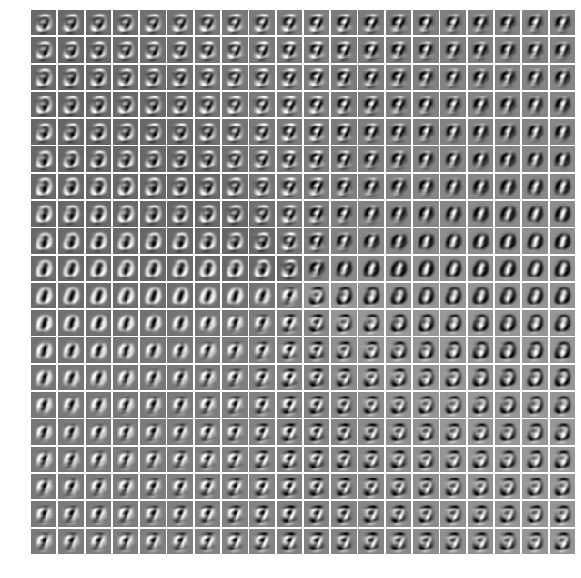

In [36]:
if 0:
    # This cell generates a grid of 2d reconstructions form the first 2 componenets.
    # It can be compared with a similar grid opained using a 2D VAE
    z_mesh_x, z_mesh_y = np.meshgrid(np.linspace(-3, 3, 20), np.linspace(-3, 3, 20))
    z_mesh = np.concatenate([z_mesh_x.reshape(-1, 1), 
                             z_mesh_y.reshape(-1, 1)], axis=1)
    rec2d = Uk.dot(z_mesh.T).T.reshape(-1, 1, 28,28)
    plt.figure(figsize=(10, 10))
    plot_mat(rec2d, prop=(1,1), cmap='gray')

In [33]:
rec2d.shape

(400, 28, 28)

We can encode a data sample by simple linear projection

Text(0,0.5,'Sum of per-pixel square reconstruction differences')

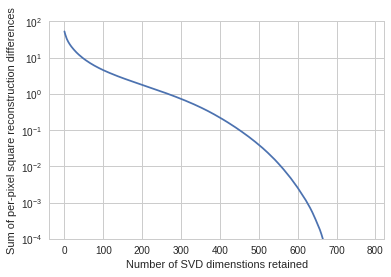

In [18]:
# The spectrum of singular values can tell us what is the actual 
# dimensionality of data
plt.semilogy(np.cumsum(S[::-1]**2)[::-1] / mnist_full_train_data_flat.shape[0])
plt.grid(True)
plt.ylim(1e-4, 1e2)
plt.xlabel('Number of SVD dimenstions retained')
plt.ylabel('Sum of per-pixel square reconstruction differences')

In [16]:
Z = Uk.T.dot(X) # = Sk * Vk_t
Xhat1 = Uk.dot(Z)
print("Maximum difference between using the matrix factorizatoin and linear projection",
      np.abs(Xhat - Xhat1).max())

Maximum difference between using the matrix factorizatoin and linear projection 1.2516975e-06


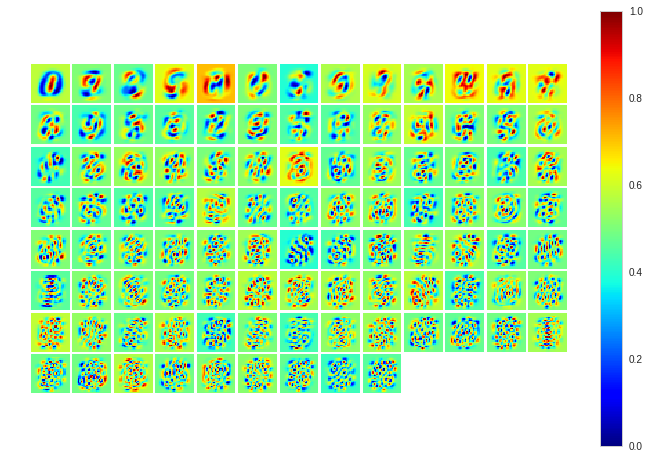

In [17]:
# most ditionary elements affect all pixels
plt.figure(figsize=(12, 8))
plot_mat(U.T[:100, :].reshape(-1, 1, 28, 28), cmap='jet', colorbar=True)

# Sparse Autoencoder

In [0]:
import spams

We'll learn matrices $D$ and $Z$ such that:

$$
D,Z = \text{argmin}_{D,Z} || X - DZ||^2_2 + \lambda_1||Z||_1 + 0.5\lambda_2 ||Z||^2_2
$$

where the norm operators $||\cdot||_2$ and $||\cdot||_1$ are the first and second norm of the flattened matrices.

Mean per-pixel err: 5.50105


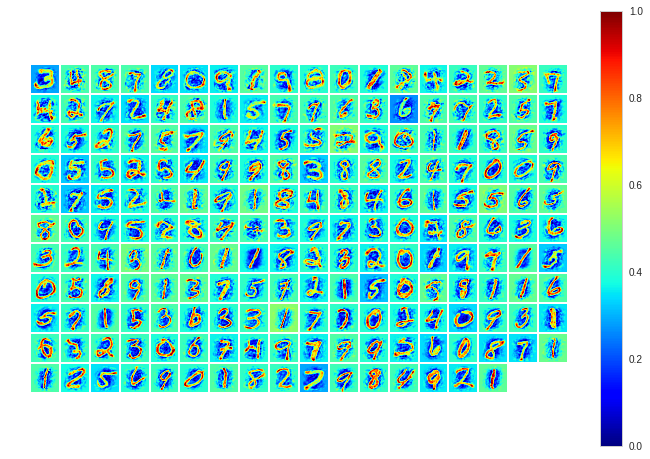

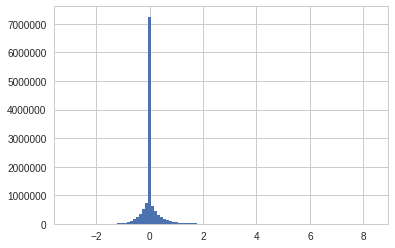

In [17]:
lambda1=0.1

X = mnist_full_train_data_flat_norm.T

D = spams.trainDL(X, K=196, lambda1=lambda1)

# note that to get the actual encoding Z, we must solve an optimizatoin problem
Z = spams.lasso(X, D=D, lambda1=lambda1)
Z = np.asarray(Z.todense())

R = D.dot(Z)

print ("Mean per-pixel err: %g" %
       (np.sum((X - R)**2) / 
        mnist_full_train_data_flat_norm.shape[0]))

plt.figure(figsize=(12,8))
plot_mat(D.T.reshape(-1, 1, 28, 28), cmap='jet', colorbar=True)

plt.figure()
_ = plt.hist(Z.ravel(), 100)

Uses of sparse coding

Consider the following figure from J Mairal (http://www.machinelearning.org/archive/icml2009/papers/364.pdf):

<img src="https://github.com/janchorowski/nn_assignments/raw/nn17_spring/lecture_notebooks/13-sparse-coding-inpainting.jpg">

The goal is to reconstruct the image. We can to do it by:
1. learning a dictionary for patches from natural images. Crucially, we assume that:
    - images will be easy to encode using the dictionary
    - non-images will be difficult to encode
  
  The dictionary can look like this:
  
  <img src="https://github.com/janchorowski/nn_assignments/raw/nn17_spring/lecture_notebooks/13-img_codebook.png">
  
2. Split the image into overlapping patches, find an encoding for all patches to properly reconstruct the known pixels
3. Use the encoding to inpaint the missing pixels!


# Neural autoencoder

In [0]:
if 0: # vanilla autoencoder, no sparsity
    num_hidden = 196
    encoder_activation = torch.tanh
    sparsity_penalty = 0.
    enc_weight_decay = 1e-4
    dec_weight_decay = 1e-4
else: # sparse autoencoder
    #
    # Please note, that we want the latent code to be sparse and close to binary.
    # Simply forcing the code to have a small mean, leads to the suboptimal solution
    # In which small codes are counteracted by large decoding weights.
    # We enforce a large weight decay on the decoder, to prevent this behavior.
    #
    num_hidden = 196
    encoder_activation = torch.sigmoid
    sparsity_penalty = 1.0e2
    desired_sparsity = 0.05
    enc_weight_decay = 1e-4
    dec_weight_decay = 5e-2

class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.enc_layer = torch.nn.Linear(28 * 28, num_hidden)
        self.dec_layer = torch.nn.Linear(num_hidden, 28 * 28)
    
    def forward(self, x):
        orig_size = x.size()
        x = x.view(x.size(0), -1)
        z = encoder_activation(self.enc_layer(x))
        r = self.dec_layer(z)
        r = r.view(orig_size)
        return r, z

def aenc_loss(x, r, z):
    N = x.size(0)
    loss = (x - r).pow(2).sum() / N
    stats = {'rec': loss.item()}
    if sparsity_penalty > 0:
        loss_sparse = (z.mean(0) - desired_sparsity).pow(2).sum()
        loss += loss_sparse * sparsity_penalty
        stats['sparse'] = loss_sparse.item()
    return loss, stats

In [0]:
model = AutoEncoder()
optimizer = torch.optim.Adam(
    [{'params': model.enc_layer.parameters(), 'weight_decay': enc_weight_decay},
     {'params': model.dec_layer.parameters(), 'weight_decay': dec_weight_decay}],
    lr=1e-4)
global_step = 0

In [73]:
model.train()

model.to('cuda')
train_loader.to('cuda')

for epoch in range(100):
    for inum, (batch_x, ) in enumerate(train_loader):
        global_step += 1
        optimizer.zero_grad()
        reconstruction, z = model(batch_x)
        loss, stats = aenc_loss(batch_x, reconstruction, z)
        loss.backward()
        optimizer.step()
        if (global_step%1000) == 1:
            print("global step: %d (epoch: %d, step: %d), loss: %f %s" % 
                  (global_step, epoch, inum, loss.item(), stats))

global step: 1 (epoch: 0, step: 0), loss: 4091.700928 {'rec': 151.62855529785156, 'sparse': 39.40072250366211}
global step: 1001 (epoch: 1, step: 400), loss: 82.077126 {'rec': 66.41508483886719, 'sparse': 0.15662041306495667}
global step: 2001 (epoch: 3, step: 200), loss: 60.935738 {'rec': 59.97331237792969, 'sparse': 0.009624240919947624}
global step: 3001 (epoch: 5, step: 0), loss: 55.166077 {'rec': 54.44890594482422, 'sparse': 0.007171700708568096}
global step: 4001 (epoch: 6, step: 400), loss: 53.030579 {'rec': 52.30897521972656, 'sparse': 0.0072160521522164345}
global step: 5001 (epoch: 8, step: 200), loss: 50.465706 {'rec': 50.36383056640625, 'sparse': 0.00101876026019454}
global step: 6001 (epoch: 10, step: 0), loss: 46.282127 {'rec': 46.15827178955078, 'sparse': 0.0012385464506223798}
global step: 7001 (epoch: 11, step: 400), loss: 43.690002 {'rec': 42.67636489868164, 'sparse': 0.010136363096535206}
global step: 8001 (epoch: 13, step: 200), loss: 39.866703 {'rec': 37.7049064636

KeyboardInterrupt: ignored

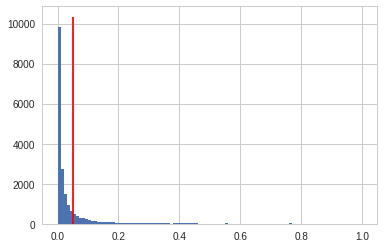

In [74]:
model.eval()
_, z = model(torch.tensor(mnist_full_train_data[:100], device=batch_x.device))
_ = plt.hist(n(z).ravel(), 100)
plt.vlines(desired_sparsity, *plt.ylim(), color='r')

Text(0.5,1,'Encoder weights')

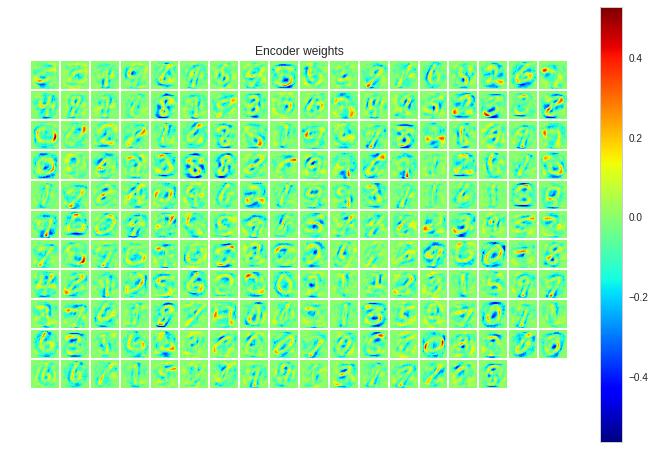

In [75]:
plt.figure(figsize=(12,8))
W_enc = model.enc_layer.weight.view(-1, 1, 28, 28)
plot_mat(n(W_enc), scaleIndividual=False, colorbar=True, cmap='jet')
plt.title('Encoder weights')

Text(0.5,1,'Decoder weights')

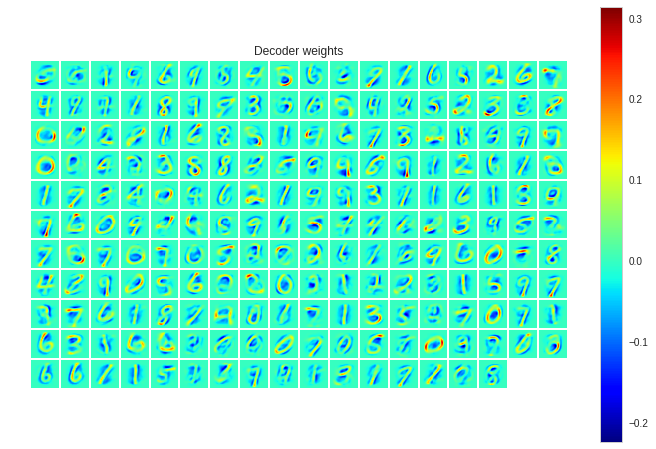

In [76]:
plt.figure(figsize=(12,8))
W_enc = model.dec_layer.weight.t().view(-1, 1, 28, 28)
plot_mat(n(W_enc), scaleIndividual=False, colorbar=True, cmap='jet')
plt.title('Decoder weights')

# Further reading

More information on autoencoders: https://blog.keras.io/building-autoencoders-in-keras.html